In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
import sys
import os

import xarray as xr
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from cartopy import crs, feature

sys.path.insert(0, '../python')

import data
import viz

plt.rcParams['figure.dpi'] = 120

# Loading data

## Loading surface data from data-based products

### Getting the file names 

In [3]:
varname = 'fgco2'
# read in some file names. Exclusions should be done on a per-file basis
flist_prods = data.get_fnames_recursive_search(  
    basedir='/nfs/kryo/work/updata/reccap2/Surface_CO2/',
    include=[varname, '.nc'],  # include the file names that contain spco2 and .nc
    exclude=['ensemble', 'NIES-rf', 'Wat', 'glob', 'reg']  # exclude the second NIES model and the ensemble of LDEO and Watson
)
print(flist_prods)

flist_wat20 = data.get_fnames_recursive_search(  
    basedir='/nfs/kryo/work/updata/reccap2/Surface_CO2/',
    include=[varname, 'Wat', '.nc'],  # include the file names that contain spco2 and .nc and Watson20
    exclude=['glob', 'reg']
)

['/nfs/kryo/work/updata/reccap2/Surface_CO2/AOML_EXTRAT_v20211130/fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/CMEMS-LSCE-FFNN_v20210709/fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/CSIRML6_v20211117/fgco2_CSIRML6_1985-2018_v20211117.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/JMAMLR_v20211208/fgco2_JMAMLR_1985-2019_v20211208.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/JenaMLS_v20211126/fgco2_JenaMLS_1985-2018_v20211126.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/NIES-nn_v202011/RECCAP-XYT_NIES-nn_fgco2_ver202011_1985-2019.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/OceanSODAETHZ_v20211207/fgco2_OceanSODAETHZ_1985-2018_v20211207.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/SOMFFN_v20211121/fgco2_MPI_SOMFFN_1982-2019_v20211121.nc'
 '/nfs/kryo/work/updata/reccap2/Surface_CO2/spco2_LDEO_HPD_1985-2018_v20211210/fgco2_LDEO_HPD_1985-2018_v20211210.nc']


### Read in the data

In [4]:
# we can read the flist in. The files will be standardized 
# you can decide if you want to load the data in now, or later
# the spco2 from the dataset will be renamed to the model name
# note that the product name is taken from the file name - incorrect naming will not work
prods = data.open_reccap2_ocean_data(flist_prods, load_data=True)
wat20 = data.open_reccap2_ocean_data(flist_wat20, load_data=True)

/home/gregorl/.local/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


ADDED: fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4
ADDED: fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc
ADDED: fgco2_CSIRML6_1985-2018_v20211117.nc
ADDED: fgco2_JMAMLR_1985-2019_v20211208.nc
ADDED: fgco2_JenaMLS_1985-2018_v20211126.nc
ADDED: RECCAP-XYT_NIES-nn_fgco2_ver202011_1985-2019.nc
ADDED: fgco2_OceanSODAETHZ_1985-2018_v20211207.nc
ADDED: fgco2_MPI_SOMFFN_1982-2019_v20211121.nc
ADDED: fgco2_LDEO_HPD_1985-2018_v20211210.nc
Trying to merge files
ADDED: fgco2_UOEX_Wat20_1985-2019_v20211204.nc
Trying to merge files


In [5]:
# you can view the file as an xarray dataset. The processing is captured in the attributes of each dataset
prods

<xarray.Dataset>
Dimensions:          (lat: 180, lon: 360, time: 492)
Coordinates:
  * time             (time) datetime64[ns] 1980-01-15 1980-02-15 ... 2020-12-15
  * lon              (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat              (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    AOML             (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CMEMS_LSCE_FFNN  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    CSIRML6          (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    JMAMLR           (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    JenaMLS          (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    NIES_nn          (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    OceanSODAETHZ    (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    MPI_SOMFFN       (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    LDEO_HPD         (time, lat, lon) float32 nan nan nan nan ... nan nan nan

In [8]:
def get_start_and_end_year_of_valid_data(ds):
    from pandas import DataFrame
    years = {}
    for key in ds:
        mask = ds[key].notnull().any(['lat', 'lon'])
        times = mask.time.where(mask, drop=True)[[0, -1]]
        years[key] = [y for y in times.dt.year.values]

    df = DataFrame(years, index=['start', 'end']).T
    return df
    
prods_time_avg_as_array = prods.mean('time').to_array(dim='model') * (365 * 86400)
start_end_years = get_start_and_end_year_of_valid_data(prods)

/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


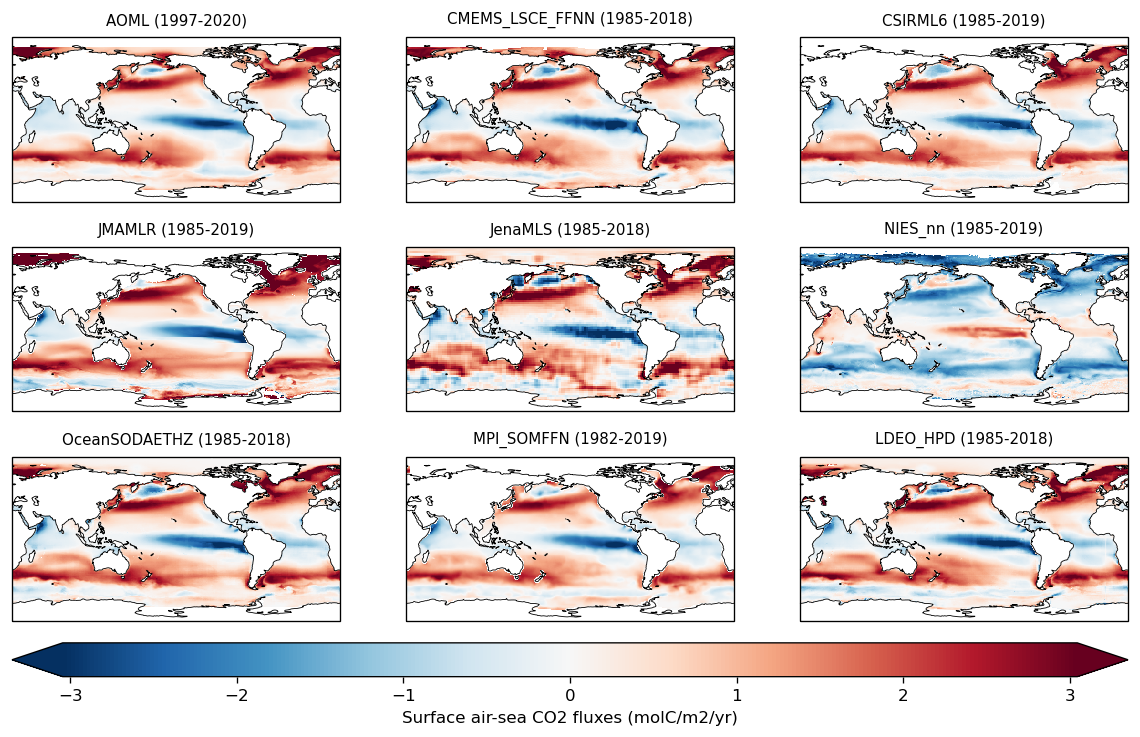

In [9]:
fg = prods_time_avg_as_array.plot(
    figsize=[12, 8],
    subplot_kws=dict(projection=crs.PlateCarree(205)),
    col='model', 
    col_wrap=3,
    robust=True,
    cbar_kwargs=dict(location='bottom', pad=0.03, aspect=30),
    transform=crs.PlateCarree(),
)

# getting the start and end years of the data so that we know the ranges
titles = [a.get_title().split('=')[1].strip() for a in fg.axes.flat]
titles = [f"{t} ({start_end_years.loc[t][0]}-{start_end_years.loc[t][1]})" for t in titles]
[a.set_title(titles[i], size=9, va='bottom') for i, a in enumerate(fg.axes.flat)]
[a.coastlines(lw=0.5, color='k') for a in fg.axes.flat]

fg.cbar.set_label('Surface air-sea CO2 fluxes (molC/m2/yr)')

plt.show()

### Saving the formatted data for later

In [47]:
data.save_dataset_with_compression(
    prods.sel(lat=slice(-80, -10)), 
    f'/home/gregorl/Projects/2021-RECCAP2-SouthernOcean/data2/SO_{varname}_dataProducts.nc')

data.save_dataset_with_compression(
    wat20.sel(lat=slice(-80, -10)), 
    f'/home/gregorl/Projects/2021-RECCAP2-SouthernOcean/data2/SO_{varname}_dataProdWat20.nc')

# Using the package to read in your own data

### Bushinsky et al. (2019) SOCCOM float ML approach

In [10]:
# first open the dataset as you would a normal xarray dataset
ds = xr.open_dataset('/nfs/kryo/work/updata/pco2_bushinsky/MPI-SOM_FFN_SOCCOMv2018.nc', drop_variables='date')

# then select the variable you're interested in (or not) and use the conform dataset function
bsk19 = data.conform_dataset(ds[[f'{varname}_smoothed']].rename(**{f"{varname}_smoothed": 'MPI_SOMFFN_SOCCOM'}))

if varname == 'fgco2':
    bsk19['MPI_SOMFFN_SOCCOM'] = (bsk19.MPI_SOMFFN_SOCCOM / (-365 * 86400)).assign_attrs(units='mol/m2/s')

# now we can save the formatted file for later - note that there is amazing compression happening here
data.save_dataset_with_compression(
    bsk19.sel(lat=slice(-80, -10)),
    f'/home/gregorl/Projects/2021-RECCAP2-SouthernOcean/data2/SO_{varname}_dataProdBsk19.nc')

### SOCAT data

In [25]:
base = '/home/gregorl/Projects/2021-RECCAP2-SouthernOcean/data2/'
fname = data.download("https://www.socat.info/socat_files/v2021/SOCATv2021_tracks_gridded_monthly.nc.zip", path=base)

In [26]:
from pyseaflux import fCO2_to_pCO2

# first open the dataset as you would a normal xarray dataset
socat = xr.open_dataset(fname)
socat = data.conform_dataset(socat).assign_attrs(model='SOCAT_fgco2_obs')
socat_so = socat.sel(time=slice('1980', '2020'), lat=slice(-80, -10))

# convert socat fCO2 to pCO2
spco2_socat = fCO2_to_pCO2(socat_so.fco2_ave_unwtd, socat_so.sst_ave_unwtd).to_dataset(name='spco2_socat')

# now we can save the formatted file for later - note that there is amazing compression happening here
data.save_dataset_with_compression(
    spco2_socat,
    f'{base}/SO_spco2_SOCAT.nc')

### Get Southern Ocean mask

In [27]:
so = data.regions.southern != 0

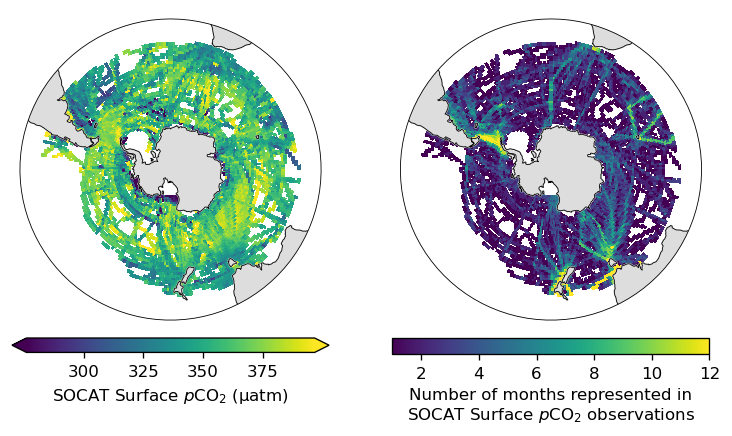

In [22]:
fig = plt.figure(figsize=(viz.fw2, viz.fw1+1), dpi=120)

socat_mean_pco2 = spco2_socat.spco2_socat.sel(lat=slice(-80, -30)).mean('time').where(so)
socat_mon_repr = (  # the number of months of the year represented in SOCAT
    spco2_socat.spco2_socat
    .sel(lat=slice(-80, -30))
    .groupby('time.month')  # groupby the month of the year to make a climatology
    .mean('time')  # averaging is just to get some sort of value 
    .count('month')  # now we count the months of the climatology 
    .where(lambda x: x != 0)  # mask out zero counts
    .where(so)  # apply the southern ocean mask
)

img1 = socat_mean_pco2.map(
    pos=121,
    proj=crs.SouthPolarStereo(), 
    round=True,
    cbar_kwargs=dict(orientation='horizontal')
)

img2 = socat_mon_repr.map(
    pos=122,
    proj=crs.SouthPolarStereo(), 
    round=True,
    cbar_kwargs=dict(orientation='horizontal'),
    robust=False,
)

img1.colorbar.set_label('SOCAT Surface $p$CO$_2$ (µatm)')
img2.colorbar.set_label('Number of months represented in\nSOCAT Surface $p$CO$_2$ observations')

# Model data

## Loading data from a manually created file list

In [18]:
manual_flist = [
  '/nfs/kryo/work/updata/reccap2/Models/3D_ALL/CESM-ETHZ_3D_ALL_v20211122/dissic_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc',
  '/nfs/kryo/work/updata/reccap2/Models/3D_ALL/CESM-ETHZ_3D_ALL_v20211122/o2_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc',
  '/nfs/kryo/work/updata/reccap2/Models/3D_ALL/CESM-ETHZ_3D_ALL_v20211122/talk_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc',
  '/nfs/kryo/work/updata/reccap2/Models/Ancillary_data/CESM-ETHZ_Ancillary_data_v20211122/volume_CESM-ETHZ_1_gr_v20211122.nc'
]

data.open_reccap2_ocean_data(manual_flist)

ADDED: dissic_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc
ADDED: o2_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc
ADDED: talk_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc
ADDED: volume_CESM-ETHZ_1_gr_v20211122.nc
Trying to merge files


<xarray.Dataset>
Dimensions:  (depth: 60, lat: 180, lon: 360, time: 39)
Coordinates:
  * depth    (depth) float32 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1980-01-15 1981-01-15 ... 2018-01-15
Data variables:
    dissic   (time, depth, lat, lon) float32 9.969e+36 9.969e+36 ... 9.969e+36
    o2       (time, depth, lat, lon) float32 9.969e+36 9.969e+36 ... 9.969e+36
    talk     (time, depth, lat, lon) float32 9.969e+36 9.969e+36 ... 9.969e+36
    volume   (depth, lat, lon) float32 -1.089e+09 -1.089e+09 ... -2.721e+10

## Automatically finding file names for model runs 

In [21]:
# read in some file names. Exclusions should be done on a per-file basis
flist_A = data.get_fnames_recursive_search(  
    basedir='/nfs/kryo/work/updata/reccap2/Models/3D_ALL',
    include=['CESM-ETHZ', 'dissic_', '_A_', '.nc'],  # include all CESM-ETHZ A run files 
)

flist_D = data.get_fnames_recursive_search(  
    basedir='/nfs/kryo/work/updata/reccap2/Models/3D_ALL',
    include=['CESM-ETHZ', 'dissic_', '_D_', '.nc'],  # include all CESM-ETHZ A run files 
)

flist_vol = data.get_fnames_recursive_search(  
    basedir='/nfs/kryo/work/updata/reccap2/Models/',
    include=['CESM-ETHZ', 'volume', '.nc'],  # include all CESM-ETHZ A run files 
)

flist_A_3D = flist_A.tolist() + flist_vol.tolist()
flist_D_3D = flist_D.tolist() + flist_vol.tolist()
flist_D_3D, flist_A_3D

(['/nfs/kryo/work/updata/reccap2/Models/3D_ALL/CESM-ETHZ_3D_ALL_v20211122/dissic_CESM-ETHZ_D_1_gr_1980-2018_v20211122.nc',
  '/nfs/kryo/work/updata/reccap2/Models/Ancillary_data/CESM-ETHZ_Ancillary_data_v20211122/volume_CESM-ETHZ_1_gr_v20211122.nc'],
 ['/nfs/kryo/work/updata/reccap2/Models/3D_ALL/CESM-ETHZ_3D_ALL_v20211122/dissic_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc',
  '/nfs/kryo/work/updata/reccap2/Models/Ancillary_data/CESM-ETHZ_Ancillary_data_v20211122/volume_CESM-ETHZ_1_gr_v20211122.nc'])

In [22]:
eth_A = data.open_reccap2_ocean_data(flist_A_3D, load_data=False)
eth_A = eth_A.where(lambda x: x < 1e34)

eth_D = data.open_reccap2_ocean_data(flist_D_3D, load_data=False)
eth_D = eth_D.where(lambda x: x < 1e34)

ADDED: dissic_CESM-ETHZ_A_1_gr_1980-2018_v20211122.nc
ADDED: volume_CESM-ETHZ_1_gr_v20211122.nc
Trying to merge files
ADDED: dissic_CESM-ETHZ_D_1_gr_1980-2018_v20211122.nc
ADDED: volume_CESM-ETHZ_1_gr_v20211122.nc
Trying to merge files


In [23]:
fnat_dissic_int = (eth_D.dissic * -eth_A.volume).load().assign_attrs(units='molC')
fant_dissic_int = ((eth_A.dissic - eth_D.dissic) * -eth_A.volume).load().assign_attrs(units='molC')

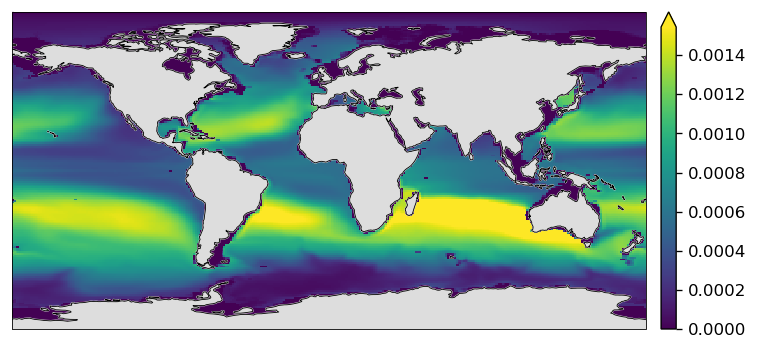

In [24]:
t0 = fant_dissic_int[0, 20:35].sum('depth', keep_attrs=True)
t1 = fant_dissic_int[-1, 20:35].sum('depth', keep_attrs=True)

fig = plt.figure(dpi=120)
((t1 - t0) * 12.011 / 1e15).map()

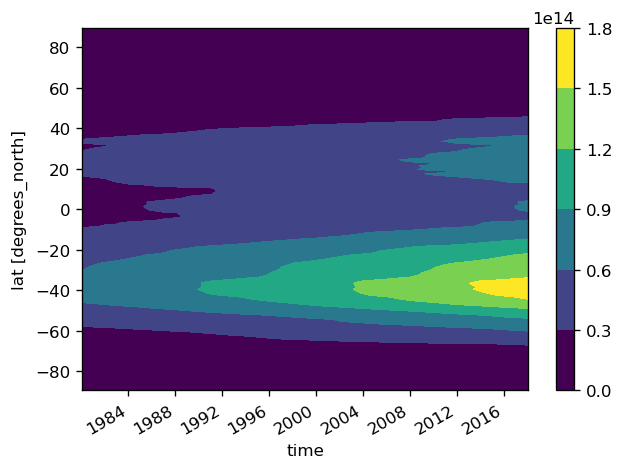

In [175]:
plt.figure(dpi=120)
fant_dissic_int.sum(['depth', 'lon']).T.plot.contourf()